# Multihead Attention


https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

Lets test multiple attention heads, one for each input, with univariate and mutivariate data

Due to a slip in the matrix profile function, the matrix profile is computed in reverse, this is adressed in the 'Multihead Attention_fwd' notebook

Feeding the matrix profile to the attention layer, and also batch normalization were attempted, however these models were not fully explored as time to submission was short

## Load data, functions

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import MultiHeadAttention, BatchNormalization, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pywt
import matrixprofile as mp
from keras import Model
from keras.layers import dot
import datetime 
from datetime import timedelta

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

In [ ]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [ ]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()

In [ ]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

In [ ]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [ ]:
def generate_training_val_examples(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))

    
    return X_train, y_train, X_val, y_val, scaler



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [ ]:
def descale_y_retrun_metrics(yhat, y_val2):
    #We will use validation data that has not had outleirs limited, will be a different min/max scaler as such
    dict_indexes=[]
    dict_dfs=[]
    for j in range(0, n_steps_out):
        RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
        for i in range(0, len(inputs)):  
            pred_descaled= (scaler.inverse_transform(yhat[:,j:j+1,:].reshape(yhat.shape[0], yhat.shape[2])))[:, i:i+1]
            groud_truth_descaled= ((scaler2.inverse_transform(y_val2[:,j:j+1,:].reshape(y_val2.shape[0], y_val2.shape[2]))))[:, i:i+1]
            RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
            MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
            MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
            MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
            R2 = r2_score(groud_truth_descaled, pred_descaled)
            RMSE_list.append(RMSE)
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            R2_list.append(R2)
            MSE_list.append(MSE)
        metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=inputs)
        dict_dfs.append(metrics_df)
        dict_indexes.append('Lookahead' +str(j))
    metrics_dict = dict(zip(dict_indexes, dict_dfs))
    return metrics_dict

In [ ]:
def generate_training_val_examples_univariate_output(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM, filter output to only the first input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))[:,:,:1]
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))[:,:,:1]

    
    return X_train, y_train, X_val, y_val, scaler

In [ ]:
def descale_y_retrun_metrics_univariate_y(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for single output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    yhat_stretched= np.repeat(yhat[:,:,0],len(inputs)).reshape(yhat.shape[0], yhat.shape[1], len(inputs))
    y_val2_stretched= np.repeat(y_val2[:,:,0],len(inputs)).reshape(y_val2.shape[0], y_val2.shape[1], len(inputs))
    
    for j in range(0, n_steps_out):
        
        
        pred_descaled= (scaler.inverse_transform(yhat_stretched[:, j:j+1, :].reshape(yhat_stretched.shape[0], yhat_stretched.shape[2])))[:,:1]
        groud_truth_descaled= (scaler.inverse_transform(array([y_val2[ :, j:j+1,0].reshape(y_val2.shape[0])]*len(inputs)).transpose()))[:,:1]
        RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
        MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
        MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
        MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
        R2 = r2_score(groud_truth_descaled, pred_descaled)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
    metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1, (n_steps_out+1)))

 
    return metrics_df

In [ ]:
def add_mp_reversed(data, window):
    #Given 3d array, add matrix profile of (x,y,0) as new dimension; new array has dimensiosn (x,y,z+1) 
    mp_list=[]
    for i in data[:,:,0]:
        profile = mp.compute(np.flip(i, axis=0), window, n_jobs=4)['mp']
        #we are padding the end of the sequence with the mean
        #matrix profile is always 1 full window size smalelr than input data
        mp_list.append(np.append(profile,([mean(profile)]*(data.shape[1]-len(profile)))))
        
    #concatenate matrix profile data with original    
    mp_array = np.array(mp_list).reshape(data.shape[0], data.shape[1])
    std_array = ((mp_array-mean(mp_array))/np.std(mp_array)).reshape(data.shape[0], data.shape[1],1)
    data = np.concatenate((data, std_array), axis=2)[:, window:, :]
    
    return data

In [ ]:
def add_mp(data, window):
    #Given 3d array, add matrix profile of (x,y,0) as new dimension; new array has dimensiosn (x,y,z+1) 
    mp_list=[]
    for i in data[:,:,0]:
        profile = mp.compute(i, window, n_jobs=4)['mp']
        #we are padding the end of the sequence with the mean
        #matrix profile is always 1 full window size smalelr than input data
        mp_list.append(np.append(([mean(profile)]*(data.shape[1]-len(profile))),profile))
        
    #concatenate matrix profile data with original    
    mp_array = np.array(mp_list).reshape(data.shape[0], data.shape[1])
    std_array = ((mp_array-mean(mp_array))/np.std(mp_array)).reshape(data.shape[0], data.shape[1],1)
    data = np.concatenate((data, std_array), axis=2)[:, window:, :]
    
    return data

## Multiple heads, all inputs

In [57]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00']
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'size', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4320
n_steps_out = 15
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window = 288

month=0
start_date=Start_dates[month]
end_date=end_dates[month]


In [60]:
mp_window=288
X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
#X_train = (add_mp_reversed(X_train, mp_window))[:,mp_window:,:]
#X_val = (add_mp_reversed(X_val, mp_window))[:,mp_window:,:]


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
def LSTM_model():    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))




    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        ]context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)


    enc_concat_attention = Concatenate(axis=2)(enc_head_list)


    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))

        dec_head_list.append(context)

    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model

In [ ]:
model = LSTM_model()

In [ ]:
model.summary()

In [76]:
y_train.shape

(3215, 15, 1)

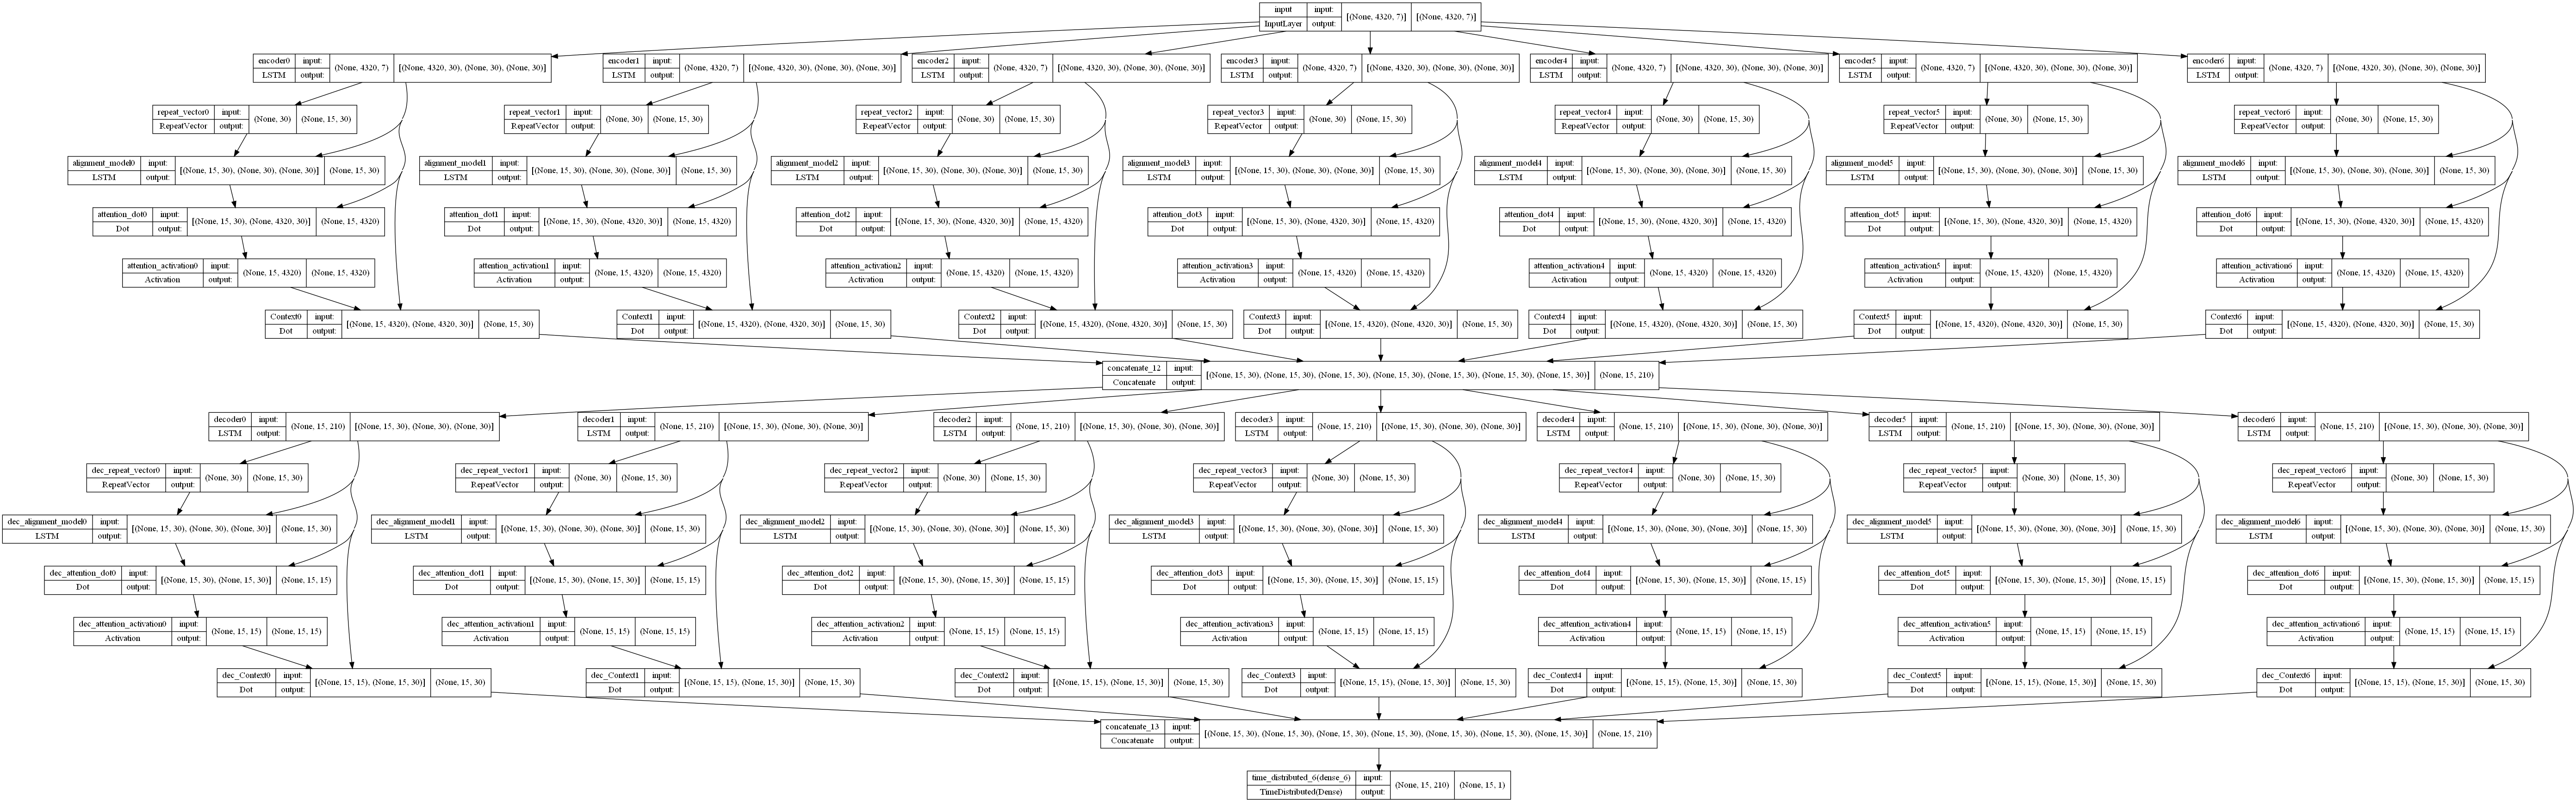

In [92]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [93]:
keras.backend.clear_session()


In [94]:
y_train.shape

(3215, 15, 1)

In [95]:
model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=10, verbose=1)

Epoch 1/10
101/101 [==============================] - 172s 1s/step - loss: 0.2719 - mae: 0.2560 - val_loss: 0.0609 - val_mae: 0.1566
Epoch 2/10
101/101 [==============================] - 99s 978ms/step - loss: 0.2351 - mae: 0.2199 - val_loss: 0.0747 - val_mae: 0.1884
Epoch 3/10
101/101 [==============================] - 98s 974ms/step - loss: 0.2290 - mae: 0.2159 - val_loss: 0.0729 - val_mae: 0.1838
Epoch 4/10
101/101 [==============================] - 99s 980ms/step - loss: 0.2257 - mae: 0.2162 - val_loss: 0.0536 - val_mae: 0.1465
Epoch 5/10
101/101 [==============================] - 98s 970ms/step - loss: 0.2216 - mae: 0.2121 - val_loss: 0.0596 - val_mae: 0.1595
Epoch 6/10
101/101 [==============================] - 98s 969ms/step - loss: 0.2155 - mae: 0.2098 - val_loss: 0.0545 - val_mae: 0.1518
Epoch 7/10
101/101 [==============================] - 99s 979ms/step - loss: 0.2142 - mae: 0.2098 - val_loss: 0.0655 - val_mae: 0.1594
Epoch 8/10
101/101 [==============================] - 99s

In [339]:
yhat_train=model.predict(X_train, verbose=1)
yhat_val = model.predict(X_val, verbose=1)
    


44/44 [==============================] - 4s 101ms/step


The model works, lets set it up with a training loop

## 1 attention layer, all inputs

In [22]:
def LSTM_model(): 
    
    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))




    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)


    enc_concat_attention = Concatenate(axis=2)(enc_head_list)



    out = TimeDistributed(Dense(y_train.shape[2]))(enc_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [24]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 403
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('1_Att_layer/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('1_Att_layer/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('1_Att_layer/val_loss.csv')
    np.save("1_Att_layer/training_metrics.npy", training_metrics_dicts)
    np.save("1_Att_layer/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
187/187 [==============================] - 76s 215ms/step - loss: 0.4562 - mae: 0.2975 - val_loss: 0.1016 - val_mae: 0.1914
Epoch 2/15
187/187 [==============================] - 33s 174ms/step - loss: 0.3956 - mae: 0.2544 - val_loss: 0.0920 - val_mae: 0.1613
Epoch 3/15
187/187 [==============================] - 32s 170ms/step - loss: 0.3829 - mae: 0.2533 - val_loss: 0.1012 - val_mae: 0.1923
Epoch 4/15
187/187 [==============================] - 32s 169ms/step - loss: 0.3647 - mae: 0.2475 - val_loss: 0.1300 - val_mae: 0.2581
Epoch 5/15
187/187 [==============================] - 32s 170ms/step - loss: 0.3574 - mae: 0.2474 - val_loss: 0.1037 - val_mae: 0.2024
Epoch 6/15
187/187 [==============================] - 31s 168ms/step - loss: 0.3399 - mae: 0.2406 - val_loss: 0.1684 - val_mae: 0.3257
Epoch 7/15
187/187 [==============================] - 31s 168ms/step - loss: 0.3325 - mae: 0.2335 - val_loss: 0.1119 - val_mae: 0.2218
Epoch 8/15
187/187 [==============================] - 3

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
193/193 [==============================] - 80s 222ms/step - loss: 0.4285 - mae: 0.3654 - val_loss: 0.4392 - val_mae: 0.3617
Epoch 2/15
193/193 [==============================] - 33s 170ms/step - loss: 0.3510 - mae: 0.3109 - val_loss: 0.4084 - val_mae: 0.3628
Epoch 3/15
193/193 [==============================] - 33s 170ms/step - loss: 0.3394 - mae: 0.3061 - val_loss: 0.3831 - val_mae: 0.3500
Epoch 4/15
193/193 [==============================] - 32s 168ms/step - loss: 0.3203 - mae: 0.2968 - val_loss: 0.3960 - val_mae: 0.3471
Epoch 5/15
193/193 [==============================] - 33s 170ms/step - loss: 0.3174 - mae: 0.2935 - val_loss: 0.3904 - val_mae: 0.3851
Epoch 6/15
193/193 [==============================] - 33s 172ms/step - loss: 0.3065 - mae: 0.2896 - val_loss: 0.3732 - val_mae: 0.3395
Epoch 7/15
193/193 [==============================] - 32s 167ms/step - loss: 0.3026 - mae: 0.2866 - val_loss: 0.3745 - val_mae: 0.3407
Epoch 8/15
193/193 [==============================] - 3

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
187/187 [==============================] - 81s 222ms/step - loss: 1.2936 - mae: 0.3156 - val_loss: 0.3028 - val_mae: 0.3162
Epoch 2/15
187/187 [==============================] - 32s 170ms/step - loss: 1.2489 - mae: 0.2747 - val_loss: 0.2751 - val_mae: 0.2563
Epoch 3/15
187/187 [==============================] - 32s 169ms/step - loss: 1.2314 - mae: 0.2667 - val_loss: 0.2816 - val_mae: 0.2882
Epoch 4/15
187/187 [==============================] - 31s 168ms/step - loss: 1.2170 - mae: 0.2667 - val_loss: 0.3055 - val_mae: 0.3302
Epoch 5/15
187/187 [==============================] - 31s 168ms/step - loss: 1.1899 - mae: 0.2682 - val_loss: 0.3963 - val_mae: 0.4071
Epoch 6/15
187/187 [==============================] - 32s 169ms/step - loss: 1.1956 - mae: 0.2692 - val_loss: 0.3039 - val_mae: 0.2945
Epoch 7/15
187/187 [==============================] - 32s 174ms/step - loss: 1.1740 - mae: 0.2619 - val_loss: 0.3079 - val_mae: 0.2987
Epoch 8/15
187/187 [==============================] - 3

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
168/168 [==============================] - 76s 228ms/step - loss: 0.1996 - mae: 0.1909 - val_loss: 0.0448 - val_mae: 0.1704
Epoch 2/15
168/168 [==============================] - 28s 168ms/step - loss: 0.1580 - mae: 0.1561 - val_loss: 0.0456 - val_mae: 0.1723
Epoch 3/15
168/168 [==============================] - 28s 168ms/step - loss: 0.1456 - mae: 0.1439 - val_loss: 0.0609 - val_mae: 0.2076
Epoch 4/15
168/168 [==============================] - 28s 169ms/step - loss: 0.1382 - mae: 0.1431 - val_loss: 0.0429 - val_mae: 0.1680
Epoch 5/15
168/168 [==============================] - 28s 168ms/step - loss: 0.1312 - mae: 0.1411 - val_loss: 0.0566 - val_mae: 0.1992
Epoch 6/15
168/168 [==============================] - 28s 169ms/step - loss: 0.1276 - mae: 0.1420 - val_loss: 0.0381 - val_mae: 0.1459
Epoch 7/15
168/168 [==============================] - 28s 169ms/step - loss: 0.1230 - mae: 0.1384 - val_loss: 0.0514 - val_mae: 0.1878
Epoch 8/15
168/168 [==============================] - 2

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
187/187 [==============================] - 80s 231ms/step - loss: 1.7227 - mae: 0.2457 - val_loss: 0.0990 - val_mae: 0.1799
Epoch 2/15
187/187 [==============================] - 32s 170ms/step - loss: 1.5610 - mae: 0.2455 - val_loss: 0.1031 - val_mae: 0.1811
Epoch 3/15
187/187 [==============================] - 32s 169ms/step - loss: 1.3971 - mae: 0.2442 - val_loss: 0.1351 - val_mae: 0.1787
Epoch 4/15
187/187 [==============================] - 31s 168ms/step - loss: 1.2458 - mae: 0.2400 - val_loss: 0.1566 - val_mae: 0.2027
Epoch 5/15
187/187 [==============================] - 33s 175ms/step - loss: 1.1491 - mae: 0.2506 - val_loss: 0.1741 - val_mae: 0.1950
Epoch 6/15
187/187 [==============================] - 31s 168ms/step - loss: 1.0081 - mae: 0.2331 - val_loss: 0.1848 - val_mae: 0.1898
Epoch 7/15
187/187 [==============================] - 32s 169ms/step - loss: 0.9846 - mae: 0.2479 - val_loss: 0.2144 - val_mae: 0.2544
Epoch 8/15
187/187 [==============================] - 3

## 2 attention layer

In [ ]:
def LSTM_model(): 
    
    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))




    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)
    enc_concat_attention = Concatenate(axis=2)(enc_head_list)
    
    
    
    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))
        dec_head_list.append(context)
    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)




    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [ ]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('2_Att_layer/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('2_Att_layer/val_loss.csv')
    np.save("2_Att_layer/training_metrics.npy", training_metrics_dicts)
    np.save("2_Att_layer/val_metrics.npy", valdiation_metrics_dicts)

## Univariate 2 layer

In [ ]:
def LSTM_model(): 
    
    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))




    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)
    enc_concat_attention = Concatenate(axis=2)(enc_head_list)
    
    
    
    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))
        dec_head_list.append(context)
    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)




    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [ ]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('Univariate/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('Univariate/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('Univariate/val_loss.csv')
    np.save("Univariate/training_metrics.npy", training_metrics_dicts)
    np.save("Univariate/val_metrics.npy", valdiation_metrics_dicts)

## 2 layer Univariate + MP

In [31]:
def LSTM_model(): 
    
    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))




    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)
    enc_concat_attention = Concatenate(axis=2)(enc_head_list)
    
    
    
    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))
        dec_head_list.append(context)
    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)




    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [43]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window = 288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('Univariate_MP/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('Univariate_MP/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('Univariate_MP/val_loss.csv')
    np.save("Univariate_MP/training_metrics.npy", training_metrics_dicts)
    np.save("Univariate_MP/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 45s 275ms/step - loss: 0.2791 - mae: 0.2759 - val_loss: 0.0647 - val_mae: 0.1632
Epoch 2/15
101/101 [==============================] - 23s 230ms/step - loss: 0.2292 - mae: 0.2136 - val_loss: 0.0891 - val_mae: 0.2115
Epoch 3/15
101/101 [==============================] - 24s 234ms/step - loss: 0.2201 - mae: 0.2049 - val_loss: 0.1013 - val_mae: 0.2350
Epoch 4/15
101/101 [==============================] - 25s 244ms/step - loss: 0.2193 - mae: 0.2019 - val_loss: 0.0747 - val_mae: 0.1991
Epoch 5/15
101/101 [==============================] - 25s 248ms/step - loss: 0.2147 - mae: 0.2008 - val_loss: 0.0646 - val_mae: 0.1676
Epoch 6/15
101/101 [==============================] - 25s 249ms/step - loss: 0.2116 - mae: 0.1979 - val_loss: 0.0591 - val_mae: 0.1704
Epoch 7/15
101/101 [==============================] - 25s 251ms/step - loss: 0.2145 - mae: 0.1992 - val_loss: 0.0564 - val_mae: 0.1676
Epoch 8/15
101/101 [==============================] - 2

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 43s 278ms/step - loss: 0.7747 - mae: 0.5228 - val_loss: 0.4307 - val_mae: 0.4244
Epoch 2/15
107/107 [==============================] - 25s 230ms/step - loss: 0.5782 - mae: 0.4084 - val_loss: 0.4634 - val_mae: 0.4725
Epoch 3/15
107/107 [==============================] - 25s 232ms/step - loss: 0.5452 - mae: 0.3895 - val_loss: 0.3754 - val_mae: 0.3582
Epoch 4/15
107/107 [==============================] - 25s 236ms/step - loss: 0.5329 - mae: 0.3876 - val_loss: 0.4009 - val_mae: 0.4098
Epoch 5/15
107/107 [==============================] - 25s 235ms/step - loss: 0.5366 - mae: 0.3809 - val_loss: 0.3615 - val_mae: 0.3477
Epoch 6/15
107/107 [==============================] - 26s 241ms/step - loss: 0.5163 - mae: 0.3697 - val_loss: 0.3643 - val_mae: 0.3543
Epoch 7/15
107/107 [==============================] - 25s 236ms/step - loss: 0.5267 - mae: 0.3711 - val_loss: 0.3757 - val_mae: 0.3826
Epoch 8/15
107/107 [==============================] - 2

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 44s 277ms/step - loss: 0.1870 - mae: 0.2582 - val_loss: 0.3367 - val_mae: 0.2372
Epoch 2/15
101/101 [==============================] - 23s 231ms/step - loss: 0.1450 - mae: 0.2035 - val_loss: 0.3173 - val_mae: 0.2347
Epoch 3/15
101/101 [==============================] - 23s 231ms/step - loss: 0.1422 - mae: 0.1998 - val_loss: 0.3168 - val_mae: 0.2396
Epoch 4/15
101/101 [==============================] - 23s 229ms/step - loss: 0.1410 - mae: 0.1985 - val_loss: 0.3161 - val_mae: 0.2503
Epoch 5/15
101/101 [==============================] - 23s 232ms/step - loss: 0.1400 - mae: 0.1965 - val_loss: 0.3143 - val_mae: 0.2590
Epoch 6/15
101/101 [==============================] - 23s 229ms/step - loss: 0.1390 - mae: 0.1980 - val_loss: 0.3129 - val_mae: 0.2546
Epoch 7/15
101/101 [==============================] - 23s 231ms/step - loss: 0.1399 - mae: 0.1990 - val_loss: 0.3125 - val_mae: 0.2411
Epoch 8/15
101/101 [==============================] - 2

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
82/82 [==============================] - 45s 323ms/step - loss: 0.2286 - mae: 0.2260 - val_loss: 0.0338 - val_mae: 0.1183
Epoch 2/15
82/82 [==============================] - 22s 270ms/step - loss: 0.1600 - mae: 0.1506 - val_loss: 0.0361 - val_mae: 0.1198
Epoch 3/15
82/82 [==============================] - 21s 258ms/step - loss: 0.1540 - mae: 0.1445 - val_loss: 0.0326 - val_mae: 0.1225
Epoch 4/15
82/82 [==============================] - 21s 259ms/step - loss: 0.1533 - mae: 0.1444 - val_loss: 0.0359 - val_mae: 0.1370
Epoch 5/15
82/82 [==============================] - 23s 278ms/step - loss: 0.1535 - mae: 0.1468 - val_loss: 0.0352 - val_mae: 0.1198
Epoch 6/15
82/82 [==============================] - 23s 279ms/step - loss: 0.1509 - mae: 0.1400 - val_loss: 0.0361 - val_mae: 0.1293
Epoch 7/15
82/82 [==============================] - 22s 274ms/step - loss: 0.1501 - mae: 0.1428 - val_loss: 0.0394 - val_mae: 0.1191
Epoch 8/15
82/82 [==============================] - 22s 266ms/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 44s 281ms/step - loss: 0.1277 - mae: 0.2028 - val_loss: 0.0416 - val_mae: 0.1233
Epoch 2/15
101/101 [==============================] - 24s 234ms/step - loss: 0.0736 - mae: 0.1517 - val_loss: 0.0396 - val_mae: 0.1174
Epoch 3/15
101/101 [==============================] - 23s 231ms/step - loss: 0.0629 - mae: 0.1452 - val_loss: 0.0446 - val_mae: 0.1240
Epoch 4/15
101/101 [==============================] - 23s 232ms/step - loss: 0.0669 - mae: 0.1416 - val_loss: 0.0426 - val_mae: 0.1254
Epoch 5/15
101/101 [==============================] - 23s 231ms/step - loss: 0.0588 - mae: 0.1356 - val_loss: 0.0416 - val_mae: 0.1211
Epoch 6/15
101/101 [==============================] - 24s 236ms/step - loss: 0.0606 - mae: 0.1367 - val_loss: 0.0405 - val_mae: 0.1159
Epoch 7/15
101/101 [==============================] - 23s 230ms/step - loss: 0.0638 - mae: 0.1374 - val_loss: 0.0443 - val_mae: 0.1296
Epoch 8/15
101/101 [==============================] - 2

In [39]:
y_train.shape

(3222, 5, 1)

In [41]:
X_train.shape

(3222, 4320, 2)

## 2 layer, all variables, MP

In [15]:
def LSTM_model(): 
    
    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))




    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)
    enc_concat_attention = Concatenate(axis=2)(enc_head_list)
    
    
    
    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))
        dec_head_list.append(context)
    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)




    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [45]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer_MP/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('2_Att_layer_MP/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('2_Att_layer_MP/val_loss.csv')
    np.save("2_Att_layer_MP/training_metrics.npy", training_metrics_dicts)
    np.save("2_Att_layer_MP/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 230s 1s/step - loss: 0.2616 - mae: 0.2533 - val_loss: 0.0528 - val_mae: 0.1468
Epoch 2/15
101/101 [==============================] - 130s 1s/step - loss: 0.2158 - mae: 0.1993 - val_loss: 0.0476 - val_mae: 0.1441
Epoch 3/15
101/101 [==============================] - 128s 1s/step - loss: 0.2151 - mae: 0.2049 - val_loss: 0.0437 - val_mae: 0.1317
Epoch 4/15
101/101 [==============================] - 130s 1s/step - loss: 0.2047 - mae: 0.1928 - val_loss: 0.0440 - val_mae: 0.1356
Epoch 5/15
101/101 [==============================] - 130s 1s/step - loss: 0.2043 - mae: 0.2001 - val_loss: 0.0438 - val_mae: 0.1361
Epoch 6/15
101/101 [==============================] - 131s 1s/step - loss: 0.1927 - mae: 0.1944 - val_loss: 0.0434 - val_mae: 0.1301
Epoch 7/15
101/101 [==============================] - 130s 1s/step - loss: 0.1846 - mae: 0.1889 - val_loss: 0.0501 - val_mae: 0.1464
Epoch 8/15
101/101 [==============================] - 130s 1s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 205s 1s/step - loss: 0.6647 - mae: 0.4603 - val_loss: 0.4036 - val_mae: 0.3517
Epoch 2/15
107/107 [==============================] - 126s 1s/step - loss: 0.5192 - mae: 0.3675 - val_loss: 0.3580 - val_mae: 0.3759
Epoch 3/15
107/107 [==============================] - 126s 1s/step - loss: 0.4879 - mae: 0.3519 - val_loss: 0.3371 - val_mae: 0.3544
Epoch 4/15
107/107 [==============================] - 125s 1s/step - loss: 0.4815 - mae: 0.3490 - val_loss: 0.5301 - val_mae: 0.5652
Epoch 5/15
107/107 [==============================] - 126s 1s/step - loss: 0.4770 - mae: 0.3539 - val_loss: 0.3283 - val_mae: 0.3484
Epoch 6/15
107/107 [==============================] - 125s 1s/step - loss: 0.4663 - mae: 0.3451 - val_loss: 0.3755 - val_mae: 0.4155
Epoch 7/15
107/107 [==============================] - 126s 1s/step - loss: 0.4467 - mae: 0.3381 - val_loss: 0.3718 - val_mae: 0.4072
Epoch 8/15
107/107 [==============================] - 126s 1s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 227s 1s/step - loss: 0.1551 - mae: 0.2172 - val_loss: 0.3418 - val_mae: 0.2363
Epoch 2/15
101/101 [==============================] - 129s 1s/step - loss: 0.1396 - mae: 0.1975 - val_loss: 0.3025 - val_mae: 0.2295
Epoch 3/15
101/101 [==============================] - 129s 1s/step - loss: 0.1362 - mae: 0.1946 - val_loss: 0.3072 - val_mae: 0.2175
Epoch 4/15
101/101 [==============================] - 129s 1s/step - loss: 0.1328 - mae: 0.1904 - val_loss: 0.3104 - val_mae: 0.2132
Epoch 5/15
101/101 [==============================] - 130s 1s/step - loss: 0.1284 - mae: 0.1867 - val_loss: 0.3000 - val_mae: 0.2221
Epoch 6/15
101/101 [==============================] - 129s 1s/step - loss: 0.1259 - mae: 0.1864 - val_loss: 0.3157 - val_mae: 0.2296
Epoch 7/15
101/101 [==============================] - 129s 1s/step - loss: 0.1231 - mae: 0.1837 - val_loss: 0.3035 - val_mae: 0.2087
Epoch 8/15
101/101 [==============================] - 129s 1s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
82/82 [==============================] - 209s 2s/step - loss: 0.1998 - mae: 0.2085 - val_loss: 0.0642 - val_mae: 0.1690
Epoch 2/15
82/82 [==============================] - 105s 1s/step - loss: 0.1483 - mae: 0.1407 - val_loss: 0.0564 - val_mae: 0.1616
Epoch 3/15
82/82 [==============================] - 105s 1s/step - loss: 0.1442 - mae: 0.1378 - val_loss: 0.0399 - val_mae: 0.1218
Epoch 4/15
82/82 [==============================] - 105s 1s/step - loss: 0.1381 - mae: 0.1311 - val_loss: 0.0383 - val_mae: 0.1466
Epoch 5/15
82/82 [==============================] - 105s 1s/step - loss: 0.1374 - mae: 0.1346 - val_loss: 0.0360 - val_mae: 0.1165
Epoch 6/15
82/82 [==============================] - 105s 1s/step - loss: 0.1292 - mae: 0.1280 - val_loss: 0.0397 - val_mae: 0.1307
Epoch 7/15
82/82 [==============================] - 105s 1s/step - loss: 0.1289 - mae: 0.1260 - val_loss: 0.0357 - val_mae: 0.1182
Epoch 8/15
82/82 [==============================] - 105s 1s/step - loss: 0.1252 - m

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 234s 1s/step - loss: 0.1029 - mae: 0.1813 - val_loss: 0.0795 - val_mae: 0.2048
Epoch 2/15
101/101 [==============================] - 129s 1s/step - loss: 0.0684 - mae: 0.1358 - val_loss: 0.0583 - val_mae: 0.1948
Epoch 3/15
101/101 [==============================] - 128s 1s/step - loss: 0.0572 - mae: 0.1319 - val_loss: 0.0517 - val_mae: 0.1788
Epoch 4/15
101/101 [==============================] - 126s 1s/step - loss: 0.0514 - mae: 0.1270 - val_loss: 0.0727 - val_mae: 0.2214
Epoch 5/15
101/101 [==============================] - 127s 1s/step - loss: 0.0522 - mae: 0.1263 - val_loss: 0.0709 - val_mae: 0.2156
Epoch 6/15
101/101 [==============================] - 127s 1s/step - loss: 0.0477 - mae: 0.1223 - val_loss: 0.0756 - val_mae: 0.2305
Epoch 7/15
101/101 [==============================] - 127s 1s/step - loss: 0.0446 - mae: 0.1222 - val_loss: 0.0435 - val_mae: 0.1507
Epoch 8/15
101/101 [==============================] - 127s 1s/step - 

## Extend lookahead

### With MP

In [17]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer_MP_lookahead/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('2_Att_layer_MP_10lookahead/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('2_Att_layer_MP_10lookahead/val_loss.csv')
    np.save("2_Att_layer_MP_10_lookahead/training_metrics.npy", training_metrics_dicts)
    np.save("2_Att_layer_MP_10_lookahead/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 242s 2s/step - loss: 0.2784 - mae: 0.2689 - val_loss: 0.0536 - val_mae: 0.1489
Epoch 2/15
101/101 [==============================] - 126s 1s/step - loss: 0.2262 - mae: 0.2108 - val_loss: 0.0583 - val_mae: 0.1807
Epoch 3/15
101/101 [==============================] - 124s 1s/step - loss: 0.2224 - mae: 0.2150 - val_loss: 0.0643 - val_mae: 0.1982
Epoch 4/15
101/101 [==============================] - 125s 1s/step - loss: 0.2142 - mae: 0.2059 - val_loss: 0.0492 - val_mae: 0.1435
Epoch 5/15
101/101 [==============================] - 125s 1s/step - loss: 0.2060 - mae: 0.2005 - val_loss: 0.0637 - val_mae: 0.1753
Epoch 6/15
101/101 [==============================] - 123s 1s/step - loss: 0.2022 - mae: 0.2025 - val_loss: 0.0512 - val_mae: 0.1447
Epoch 7/15
101/101 [==============================] - 122s 1s/step - loss: 0.1983 - mae: 0.1970 - val_loss: 0.0555 - val_mae: 0.1486
Epoch 8/15
101/101 [==============================] - 121s 1s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 226s 1s/step - loss: 0.6513 - mae: 0.4521 - val_loss: 0.4248 - val_mae: 0.4212
Epoch 2/15
107/107 [==============================] - 129s 1s/step - loss: 0.5657 - mae: 0.3966 - val_loss: 0.4748 - val_mae: 0.5053
Epoch 3/15
107/107 [==============================] - 130s 1s/step - loss: 0.5294 - mae: 0.3762 - val_loss: 0.3944 - val_mae: 0.3664
Epoch 4/15
107/107 [==============================] - 129s 1s/step - loss: 0.5181 - mae: 0.3767 - val_loss: 0.4534 - val_mae: 0.4569
Epoch 5/15
107/107 [==============================] - 129s 1s/step - loss: 0.5055 - mae: 0.3722 - val_loss: 0.4311 - val_mae: 0.4175
Epoch 6/15
107/107 [==============================] - 128s 1s/step - loss: 0.4936 - mae: 0.3676 - val_loss: 0.4277 - val_mae: 0.4238
Epoch 7/15
107/107 [==============================] - 130s 1s/step - loss: 0.4686 - mae: 0.3575 - val_loss: 0.4833 - val_mae: 0.4850
Epoch 8/15
107/107 [==============================] - 129s 1s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 232s 1s/step - loss: 0.1699 - mae: 0.2342 - val_loss: 0.3427 - val_mae: 0.2746
Epoch 2/15
101/101 [==============================] - 122s 1s/step - loss: 0.1536 - mae: 0.2131 - val_loss: 0.3383 - val_mae: 0.2818
Epoch 3/15
101/101 [==============================] - 121s 1s/step - loss: 0.1474 - mae: 0.2064 - val_loss: 0.3444 - val_mae: 0.2615
Epoch 4/15
101/101 [==============================] - 122s 1s/step - loss: 0.1417 - mae: 0.2032 - val_loss: 0.3449 - val_mae: 0.2894
Epoch 5/15
101/101 [==============================] - 122s 1s/step - loss: 0.1358 - mae: 0.1987 - val_loss: 0.3592 - val_mae: 0.2929
Epoch 6/15
101/101 [==============================] - 122s 1s/step - loss: 0.1323 - mae: 0.1998 - val_loss: 0.3758 - val_mae: 0.3478
Epoch 7/15
101/101 [==============================] - 122s 1s/step - loss: 0.1262 - mae: 0.1928 - val_loss: 0.3588 - val_mae: 0.2766
Epoch 8/15
101/101 [==============================] - 122s 1s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
82/82 [==============================] - 204s 1s/step - loss: 0.2052 - mae: 0.2052 - val_loss: 0.1278 - val_mae: 0.2936
Epoch 2/15
82/82 [==============================] - 99s 1s/step - loss: 0.1611 - mae: 0.1534 - val_loss: 0.0611 - val_mae: 0.1708
Epoch 3/15
82/82 [==============================] - 100s 1s/step - loss: 0.1582 - mae: 0.1530 - val_loss: 0.0441 - val_mae: 0.1518
Epoch 4/15
82/82 [==============================] - 98s 1s/step - loss: 0.1548 - mae: 0.1487 - val_loss: 0.0586 - val_mae: 0.1656
Epoch 5/15
82/82 [==============================] - 98s 1s/step - loss: 0.1488 - mae: 0.1375 - val_loss: 0.0453 - val_mae: 0.1324
Epoch 6/15
82/82 [==============================] - 99s 1s/step - loss: 0.1438 - mae: 0.1367 - val_loss: 0.0457 - val_mae: 0.1401
Epoch 7/15
82/82 [==============================] - 100s 1s/step - loss: 0.1443 - mae: 0.1429 - val_loss: 0.0439 - val_mae: 0.1353
Epoch 8/15
82/82 [==============================] - 99s 1s/step - loss: 0.1369 - mae: 0

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 229s 1s/step - loss: 0.1238 - mae: 0.1941 - val_loss: 0.0546 - val_mae: 0.1653
Epoch 2/15
101/101 [==============================] - 123s 1s/step - loss: 0.0750 - mae: 0.1432 - val_loss: 0.0973 - val_mae: 0.2271
Epoch 3/15
101/101 [==============================] - 122s 1s/step - loss: 0.0725 - mae: 0.1474 - val_loss: 0.0451 - val_mae: 0.1453
Epoch 4/15
101/101 [==============================] - 122s 1s/step - loss: 0.0628 - mae: 0.1370 - val_loss: 0.0780 - val_mae: 0.2378
Epoch 5/15
101/101 [==============================] - 121s 1s/step - loss: 0.0620 - mae: 0.1369 - val_loss: 0.0669 - val_mae: 0.1927
Epoch 6/15
101/101 [==============================] - 122s 1s/step - loss: 0.0611 - mae: 0.1399 - val_loss: 0.0693 - val_mae: 0.2039
Epoch 7/15
101/101 [==============================] - 122s 1s/step - loss: 0.0529 - mae: 0.1294 - val_loss: 0.0632 - val_mae: 0.1949
Epoch 8/15
101/101 [==============================] - 122s 1s/step - 

### No MP

In [18]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [4]:
    n_steps_in = 4032
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)

    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer_10_lookahead/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    #pd.DataFrame(train_loss_list).to_csv('2_Att_layer_10_lookahead/train_loss.csv')
    #pd.DataFrame(val_loss_list).to_csv('2_Att_layer_10_lookahead/val_loss.csv')
    #np.save("2_Att_layer_10_lookahead/training_metrics.npy", training_metrics_dicts)
    #np.save("2_Att_layer_10_lookahead/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 224s 1s/step - loss: 0.1133 - mae: 0.1873 - val_loss: 0.0470 - val_mae: 0.1555
Epoch 2/15
107/107 [==============================] - 129s 1s/step - loss: 0.0758 - mae: 0.1494 - val_loss: 0.0639 - val_mae: 0.2018
Epoch 3/15
107/107 [==============================] - 133s 1s/step - loss: 0.0759 - mae: 0.1467 - val_loss: 0.0630 - val_mae: 0.1982
Epoch 4/15
107/107 [==============================] - 139s 1s/step - loss: 0.0622 - mae: 0.1357 - val_loss: 0.0551 - val_mae: 0.1871
Epoch 5/15
107/107 [==============================] - 144s 1s/step - loss: 0.0667 - mae: 0.1334 - val_loss: 0.0585 - val_mae: 0.1978
Epoch 6/15
107/107 [==============================] - 137s 1s/step - loss: 0.0629 - mae: 0.1302 - val_loss: 0.0733 - val_mae: 0.2311
Epoch 7/15
107/107 [==============================] - 135s 1s/step - loss: 0.0552 - mae: 0.1279 - val_loss: 0.0708 - val_mae: 0.2229
Epoch 8/15
107/107 [==============================] - 134s 1s/step - 

loop was ended after 4 months; rerun for final month and results appended

In [25]:
training_metrics_dicts[0].to_numpy().shape
valdiation_metrics_dicts[0].to_numpy().shape

(10, 5)

In [23]:
val_metrics = np.load("2_Att_layer_10_lookahead/val_metrics.npy", allow_pickle=True)
train_metrics = np.load("2_Att_layer_10_lookahead/training_metrics.npy", allow_pickle=True)

In [28]:
val_metrics= np.concatenate((val_metrics, valdiation_metrics_dicts[0].to_numpy().reshape(1,10,5)), axis=0)
train_metrics = np.concatenate((train_metrics, training_metrics_dicts[0].to_numpy().reshape(1,10,5)), axis=0)

In [30]:
np.save("2_Att_layer_10_lookahead/training_metrics.npy", train_metrics)
np.save("2_Att_layer_10_lookahead/val_metrics.npy", val_metrics)

## Visualize forecasts


In [ ]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
n_steps_in = 4032
model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
model.load_weights(('2_Att_layer_MP_10_lookahead/Month0' ))

In [129]:
yhat= model.predict(X_val)

In [143]:
def get_val_dates(): 
    series =data[:end_date].index.values.astype(np.int64) // 10 ** 9
    x,y = split_sequence(series,n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    x_train, x_val = np.split(x, [int(0.7 * len(x))])
    Y_train, Y_val_timestamps = np.split(y, [int(0.7 * len(y))])
    return Y_val_timestamps


In [144]:
def generate_ticks_lables(X_train, X_val, y_train, y_val, tick_interval, n_step_lookahead):
    ticks=np.arange(0,len(y_val),tick_interval)
    DATE_TIME_STRING_FORMAT='%m-%d %H:%M'
    y_val_ts = get_val_dates()
    label_ts = y_val_ts[:,n_step_lookahead-1][0::tick_interval]
    labels=[]
    for i in label_ts:
        labels.append(datetime.fromtimestamp(i).strftime('%m-%d %H:%M'))
    
    
     
    labels=labels[:len(ticks)]
    return ticks, labels

In [145]:
n_steps_in = 4032+288
ticks, labels = generate_ticks_lables(X_train, X_val, y_train, y_val, 144, 1)

In [146]:
## Descale, select lookahead
j=0

yhat_stretched= np.repeat(yhat[:,:,0],len(inputs)).reshape(yhat.shape[0], yhat.shape[1], len(inputs))
y_val_stretched= np.repeat(y_val[:,:,0],len(inputs)).reshape(y_val.shape[0], y_val.shape[1], len(inputs))
                  
pred_descaled= (scaler.inverse_transform(yhat_stretched[:, j:j+1, :].reshape(yhat_stretched.shape[0], yhat_stretched.shape[2])))[:,:1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val[ :, j:j+1,0].reshape(y_val.shape[0])]*len(inputs)).transpose()))[:,:1]

RMSE 13.530172200218043
MAE 8.256813737716246
MAPE 0.1147733693648568
R^2 0.6689435120704262


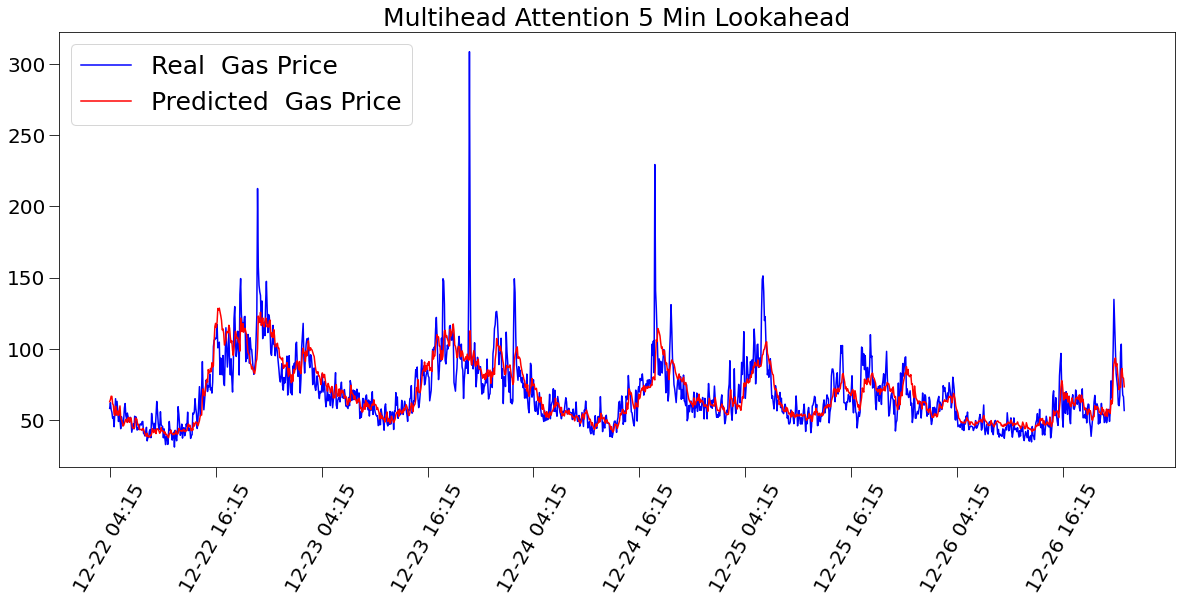

In [147]:

f, (ax3) = plt.subplots(1, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(8)
ax3.set_title('Multihead Attention 5 Min Lookahead', size=25)
ax3.plot(groud_truth_descaled, color='blue',label='Real '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Predicted '+' Gas Price')

ax3.legend(loc='upper left',prop={'size': 25})
plt.setp(ax3, xticks=ticks, xticklabels=labels)
ax3.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax3.tick_params(axis='y', labelsize=20,size=10)

print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

In [148]:
ticks, labels = generate_ticks_lables(X_train, X_val, y_train, y_val, 144, 10)

In [149]:
## Descale, select lookahead
j=9

yhat_stretched= np.repeat(yhat[:,:,0],len(inputs)).reshape(yhat.shape[0], yhat.shape[1], len(inputs))
y_val_stretched= np.repeat(y_val[:,:,0],len(inputs)).reshape(y_val.shape[0], y_val.shape[1], len(inputs))
                  
pred_descaled= (scaler.inverse_transform(yhat_stretched[:, j:j+1, :].reshape(yhat_stretched.shape[0], yhat_stretched.shape[2])))[:,:1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val[ :, j:j+1,0].reshape(y_val.shape[0])]*len(inputs)).transpose()))[:,:1]

RMSE 17.485176249955913
MAE 11.856096469603216
MAPE 0.1680202094965717
R^2 0.4473294064902733


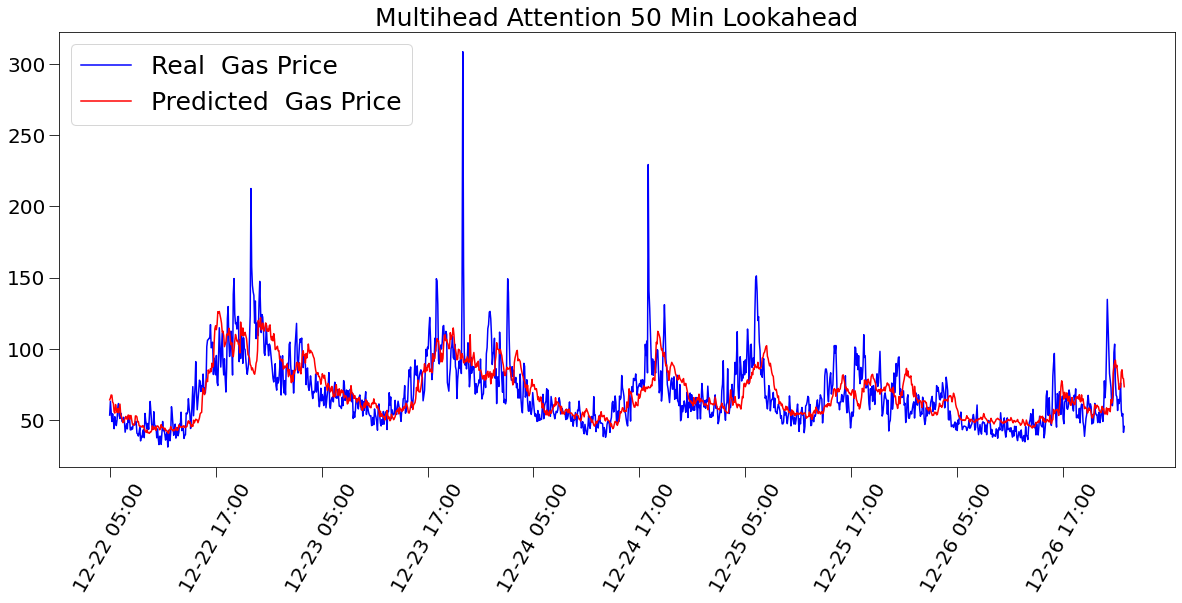

In [150]:

f, (ax3) = plt.subplots(1, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(8)
ax3.set_title('Multihead Attention 50 Min Lookahead', size=25)
ax3.plot(groud_truth_descaled, color='blue',label='Real '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Predicted '+' Gas Price')

ax3.legend(loc='upper left',prop={'size': 25})
plt.setp(ax3, xticks=ticks, xticklabels=labels)
ax3.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax3.tick_params(axis='y', labelsize=20,size=10)

print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Feed MP to attention Layer

### First layer only

In [56]:
def LSTM_model():    


    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))
    



    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        
        mp=input_train[:,:,-1]
        mp_repeat=RepeatVector((X_train.shape[1]), name='repeat_vector_mp'+str(i))(mp)
        mp_weighted_hidden_states = dot([mp_repeat, encoder_stack_h], axes=[2,1],name='mp_weighted_hidden_states'+str(i))
        
        
        context = dot([attention, mp_weighted_hidden_states], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)


    enc_concat_attention = Concatenate(axis=2)(enc_head_list)


    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))

        dec_head_list.append(context)

    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [57]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer_MPatt/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('2_Att_layer_MPatt/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('2_Att_layer_MPatt/val_loss.csv')
    np.save("2_Att_layer_MPatt/training_metrics.npy", training_metrics_dicts)
    np.save("2_Att_layer_MPatt/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 276s 2s/step - loss: 0.3647 - mae: 0.3660 - val_loss: 0.1472 - val_mae: 0.3063
Epoch 2/15
101/101 [==============================] - 172s 2s/step - loss: 0.3341 - mae: 0.3371 - val_loss: 0.1239 - val_mae: 0.2705
Epoch 3/15
101/101 [==============================] - 171s 2s/step - loss: 0.3308 - mae: 0.3316 - val_loss: 0.1436 - val_mae: 0.3078
Epoch 4/15
101/101 [==============================] - 171s 2s/step - loss: 0.3307 - mae: 0.3329 - val_loss: 0.1397 - val_mae: 0.3001
Epoch 5/15
101/101 [==============================] - 171s 2s/step - loss: 0.3251 - mae: 0.3276 - val_loss: 0.1658 - val_mae: 0.2998
Epoch 6/15
101/101 [==============================] - 171s 2s/step - loss: 0.3207 - mae: 0.3280 - val_loss: 0.1058 - val_mae: 0.2284
Epoch 7/15
101/101 [==============================] - 170s 2s/step - loss: 0.3226 - mae: 0.3270 - val_loss: 0.1195 - val_mae: 0.2492
Epoch 8/15
101/101 [==============================] - 171s 2s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 253s 2s/step - loss: 0.9240 - mae: 0.6051 - val_loss: 0.7800 - val_mae: 0.5894
Epoch 2/15
107/107 [==============================] - 171s 2s/step - loss: 0.8568 - mae: 0.5786 - val_loss: 0.8092 - val_mae: 0.5947
Epoch 3/15
107/107 [==============================] - 171s 2s/step - loss: 0.8361 - mae: 0.5667 - val_loss: 0.7785 - val_mae: 0.5294
Epoch 4/15
107/107 [==============================] - 171s 2s/step - loss: 0.8263 - mae: 0.5633 - val_loss: 0.7510 - val_mae: 0.5818
Epoch 5/15
107/107 [==============================] - 170s 2s/step - loss: 0.8040 - mae: 0.5534 - val_loss: 0.8629 - val_mae: 0.5731
Epoch 6/15
107/107 [==============================] - 171s 2s/step - loss: 0.7892 - mae: 0.5403 - val_loss: 0.8913 - val_mae: 0.5872
Epoch 7/15
107/107 [==============================] - 171s 2s/step - loss: 0.7836 - mae: 0.5394 - val_loss: 0.8110 - val_mae: 0.5544
Epoch 8/15
107/107 [==============================] - 170s 2s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 271s 2s/step - loss: 0.2965 - mae: 0.3689 - val_loss: 0.4829 - val_mae: 0.3957
Epoch 2/15
101/101 [==============================] - 172s 2s/step - loss: 0.2364 - mae: 0.3173 - val_loss: 0.4696 - val_mae: 0.4154
Epoch 3/15
101/101 [==============================] - 171s 2s/step - loss: 0.2322 - mae: 0.3118 - val_loss: 0.4846 - val_mae: 0.3838
Epoch 4/15
101/101 [==============================] - 172s 2s/step - loss: 0.2311 - mae: 0.3115 - val_loss: 0.4672 - val_mae: 0.3777
Epoch 5/15
101/101 [==============================] - 171s 2s/step - loss: 0.2338 - mae: 0.3131 - val_loss: 0.4853 - val_mae: 0.3796
Epoch 6/15
101/101 [==============================] - 171s 2s/step - loss: 0.2301 - mae: 0.3119 - val_loss: 0.4852 - val_mae: 0.4141
Epoch 7/15
101/101 [==============================] - 173s 2s/step - loss: 0.2277 - mae: 0.3095 - val_loss: 0.4851 - val_mae: 0.3744
Epoch 8/15
101/101 [==============================] - 173s 2s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
82/82 [==============================] - 242s 2s/step - loss: 0.2468 - mae: 0.2585 - val_loss: 0.1266 - val_mae: 0.2539
Epoch 2/15
82/82 [==============================] - 140s 2s/step - loss: 0.2186 - mae: 0.2256 - val_loss: 0.1001 - val_mae: 0.2236
Epoch 3/15
82/82 [==============================] - 138s 2s/step - loss: 0.2176 - mae: 0.2200 - val_loss: 0.1067 - val_mae: 0.2441
Epoch 4/15
82/82 [==============================] - 139s 2s/step - loss: 0.2147 - mae: 0.2140 - val_loss: 0.1051 - val_mae: 0.2308
Epoch 5/15
82/82 [==============================] - 139s 2s/step - loss: 0.2139 - mae: 0.2103 - val_loss: 0.1008 - val_mae: 0.2371
Epoch 6/15
82/82 [==============================] - 139s 2s/step - loss: 0.2139 - mae: 0.2149 - val_loss: 0.1071 - val_mae: 0.2208
Epoch 7/15
82/82 [==============================] - 139s 2s/step - loss: 0.2138 - mae: 0.2154 - val_loss: 0.1099 - val_mae: 0.2313
Epoch 8/15
82/82 [==============================] - 139s 2s/step - loss: 0.2126 - m

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 272s 2s/step - loss: 0.1787 - mae: 0.2548 - val_loss: 0.0819 - val_mae: 0.2213
Epoch 2/15
101/101 [==============================] - 170s 2s/step - loss: 0.1523 - mae: 0.2235 - val_loss: 0.1182 - val_mae: 0.2941
Epoch 3/15
101/101 [==============================] - 170s 2s/step - loss: 0.1519 - mae: 0.2232 - val_loss: 0.0866 - val_mae: 0.2244
Epoch 4/15
101/101 [==============================] - 170s 2s/step - loss: 0.1540 - mae: 0.2244 - val_loss: 0.0893 - val_mae: 0.2497
Epoch 5/15
101/101 [==============================] - 170s 2s/step - loss: 0.1523 - mae: 0.2218 - val_loss: 0.0901 - val_mae: 0.2375
Epoch 6/15
101/101 [==============================] - 170s 2s/step - loss: 0.1496 - mae: 0.2189 - val_loss: 0.0844 - val_mae: 0.2300
Epoch 7/15
101/101 [==============================] - 170s 2s/step - loss: 0.1539 - mae: 0.2245 - val_loss: 0.0845 - val_mae: 0.2310
Epoch 8/15
101/101 [==============================] - 170s 2s/step - 

Incorrect axes used on dot products

### Correct axes on dot product of MP/hidden states


In [59]:
def LSTM_model():    


    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))
    



    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        
        mp=input_train[:,:,-1]
        mp_repeat=RepeatVector((X_train.shape[1]), name='repeat_vector_mp'+str(i))(mp)
        mp_weighted_hidden_states = dot([mp_repeat, encoder_stack_h], axes=[1,1],name='mp_weighted_hidden_states'+str(i))
        
        
        context = dot([attention, mp_weighted_hidden_states], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)


    enc_concat_attention = Concatenate(axis=2)(enc_head_list)


    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))

        dec_head_list.append(context)

    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [61]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer_MPatt2/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('2_Att_layer_MPatt2/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('2_Att_layer_MPatt2/val_loss.csv')
    np.save("2_Att_layer_MPatt2/training_metrics.npy", training_metrics_dicts)
    np.save("2_Att_layer_MPatt2/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 303s 2s/step - loss: 0.3257 - mae: 0.3236 - val_loss: 0.0856 - val_mae: 0.2210
Epoch 2/15
101/101 [==============================] - 191s 2s/step - loss: 0.2521 - mae: 0.2493 - val_loss: 0.0790 - val_mae: 0.2136
Epoch 3/15
101/101 [==============================] - 190s 2s/step - loss: 0.2505 - mae: 0.2511 - val_loss: 0.0866 - val_mae: 0.2175
Epoch 4/15
101/101 [==============================] - 189s 2s/step - loss: 0.2470 - mae: 0.2460 - val_loss: 0.0890 - val_mae: 0.2144
Epoch 5/15
101/101 [==============================] - 198s 2s/step - loss: 0.2559 - mae: 0.2577 - val_loss: 0.0764 - val_mae: 0.1957
Epoch 6/15
101/101 [==============================] - 197s 2s/step - loss: 0.2447 - mae: 0.2424 - val_loss: 0.0903 - val_mae: 0.2260
Epoch 7/15
101/101 [==============================] - 186s 2s/step - loss: 0.2343 - mae: 0.2285 - val_loss: 0.0933 - val_mae: 0.2407
Epoch 8/15
101/101 [==============================] - 205s 2s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 341s 2s/step - loss: 0.6866 - mae: 0.4822 - val_loss: 0.7619 - val_mae: 0.6042
Epoch 2/15
107/107 [==============================] - 191s 2s/step - loss: 0.5884 - mae: 0.4262 - val_loss: 0.6165 - val_mae: 0.5080
Epoch 3/15
107/107 [==============================] - 186s 2s/step - loss: 0.6022 - mae: 0.4302 - val_loss: 0.5130 - val_mae: 0.4559
Epoch 4/15
107/107 [==============================] - 186s 2s/step - loss: 0.6115 - mae: 0.4372 - val_loss: 0.5704 - val_mae: 0.4509
Epoch 5/15
107/107 [==============================] - 186s 2s/step - loss: 0.6094 - mae: 0.4255 - val_loss: 0.5594 - val_mae: 0.4492
Epoch 6/15
107/107 [==============================] - 187s 2s/step - loss: 0.5643 - mae: 0.4067 - val_loss: 0.4962 - val_mae: 0.4318
Epoch 7/15
107/107 [==============================] - 186s 2s/step - loss: 0.5605 - mae: 0.3994 - val_loss: 0.4744 - val_mae: 0.4188
Epoch 8/15
107/107 [==============================] - 186s 2s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 278s 2s/step - loss: 0.2234 - mae: 0.2986 - val_loss: 0.6296 - val_mae: 0.5031
Epoch 2/15
101/101 [==============================] - 175s 2s/step - loss: 0.1817 - mae: 0.2551 - val_loss: 0.4523 - val_mae: 0.3589
Epoch 3/15
101/101 [==============================] - 174s 2s/step - loss: 0.1689 - mae: 0.2373 - val_loss: 0.4806 - val_mae: 0.3895
Epoch 4/15
101/101 [==============================] - 175s 2s/step - loss: 0.1645 - mae: 0.2328 - val_loss: 0.4178 - val_mae: 0.3462
Epoch 5/15
101/101 [==============================] - 175s 2s/step - loss: 0.1650 - mae: 0.2326 - val_loss: 0.4033 - val_mae: 0.3394
Epoch 6/15
101/101 [==============================] - 176s 2s/step - loss: 0.1670 - mae: 0.2322 - val_loss: 0.3941 - val_mae: 0.3468
Epoch 7/15
101/101 [==============================] - 175s 2s/step - loss: 0.1609 - mae: 0.2250 - val_loss: 0.3956 - val_mae: 0.3492
Epoch 8/15
101/101 [==============================] - 175s 2s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
82/82 [==============================] - 245s 2s/step - loss: 0.2363 - mae: 0.2659 - val_loss: 0.0893 - val_mae: 0.2132
Epoch 2/15
82/82 [==============================] - 143s 2s/step - loss: 0.1874 - mae: 0.1991 - val_loss: 0.0768 - val_mae: 0.1916
Epoch 3/15
82/82 [==============================] - 144s 2s/step - loss: 0.1764 - mae: 0.1875 - val_loss: 0.0595 - val_mae: 0.1766
Epoch 4/15
82/82 [==============================] - 144s 2s/step - loss: 0.1706 - mae: 0.1775 - val_loss: 0.0866 - val_mae: 0.2182
Epoch 5/15
82/82 [==============================] - 144s 2s/step - loss: 0.1668 - mae: 0.1698 - val_loss: 0.0552 - val_mae: 0.1699
Epoch 6/15
82/82 [==============================] - 143s 2s/step - loss: 0.1675 - mae: 0.1703 - val_loss: 0.0659 - val_mae: 0.1775
Epoch 7/15
82/82 [==============================] - 143s 2s/step - loss: 0.1642 - mae: 0.1586 - val_loss: 0.0575 - val_mae: 0.1560
Epoch 8/15
82/82 [==============================] - 143s 2s/step - loss: 0.1619 - m

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 283s 2s/step - loss: 0.1505 - mae: 0.2454 - val_loss: 0.1417 - val_mae: 0.3019
Epoch 2/15
101/101 [==============================] - 176s 2s/step - loss: 0.1025 - mae: 0.1966 - val_loss: 0.0865 - val_mae: 0.2133
Epoch 3/15
101/101 [==============================] - 176s 2s/step - loss: 0.0933 - mae: 0.1865 - val_loss: 0.0678 - val_mae: 0.1956
Epoch 4/15
101/101 [==============================] - 175s 2s/step - loss: 0.0928 - mae: 0.1771 - val_loss: 0.0787 - val_mae: 0.2089
Epoch 5/15
101/101 [==============================] - 176s 2s/step - loss: 0.0845 - mae: 0.1726 - val_loss: 0.0876 - val_mae: 0.2256
Epoch 6/15
101/101 [==============================] - 176s 2s/step - loss: 0.0889 - mae: 0.1760 - val_loss: 0.0752 - val_mae: 0.2144
Epoch 7/15
101/101 [==============================] - 176s 2s/step - loss: 0.0945 - mae: 0.1770 - val_loss: 0.0788 - val_mae: 0.2043
Epoch 8/15
101/101 [==============================] - 177s 2s/step - 

## Second layer only

In [26]:
def LSTM_model():    


    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))
    



    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)

        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        

        
        
        context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        enc_head_list.append(context)


    enc_concat_attention = Concatenate(axis=2)(enc_head_list)


    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)

        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        
        
        
        mp=input_train[:,:,-1]
        mp_repeat=RepeatVector((n_hidden), name='repeat_vector_mp'+str(i))(mp)
        mp_weighted_hidden_states = dot([mp_repeat, decoder_stack_h], axes=[2,2],name='mp_weighted_hidden_states'+str(i))
        
        context = dot([attention, mp_weighted_hidden_states], axes=[2,1],name='dec_Context'+str(i))
        
        
        

        dec_head_list.append(context)

    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [18]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer_MPatt3/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('2_Att_layer_MPatt3/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('2_Att_layer_MPatt3/val_loss.csv')
    np.save("2_Att_layer_MPatt3/training_metrics.npy", training_metrics_dicts)
    np.save("2_Att_layer_MPatt3/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


ValueError: Incompatible input shapes: axis values 10 (at axis 2) != 4032 (at axis 1). Full input shapes: (None, 10, 10), (None, 4032, 10)

In [27]:
model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])

ValueError: Incompatible input shapes: axis values 4032 (at axis 2) != 30 (at axis 2). Full input shapes: (None, 30, 4032), (None, 10, 30)

## Batch Normalziation

In [14]:
def LSTM_model(): 
    
    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    
    n_hidden = 30
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=( y_train.shape[1], y_train.shape[2]))




    enc_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('encoder' +str(i)))(input_train)
        encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
        encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
        decoder_input = RepeatVector(y_train.shape[1], name='repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('attention_dot'+str(i)))
        attention = Activation('softmax', name='attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='Context'+str(i))
        context = BatchNormalization(momentum=0.6)(context)
        enc_head_list.append(context)
    enc_concat_attention = Concatenate(axis=2)(enc_head_list)
    
    
    
    dec_head_list = []
    for i in range(0, X_train.shape[2]):
        encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
            n_hidden, activation='tanh', dropout=0.2, 
            return_state=True, return_sequences=True,name=('decoder' +str(i)))(enc_concat_attention)
        encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
        encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
        decoder_input = RepeatVector(y_train.shape[1],name='dec_repeat_vector'+str(i))(encoder_last_h)
        decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
         return_state=False, return_sequences=True,name=('dec_alignment_model'+str(i)))(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
        attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name=('dec_attention_dot'+str(i)))
        attention = Activation('softmax', name='dec_attention_activation'+str(i))(attention)
        context = dot([attention, encoder_stack_h], axes=[2,1],name='dec_Context'+str(i))
        context = BatchNormalization(momentum=0.6)(context)
        dec_head_list.append(context)
    dec_concat_attention = Concatenate(axis=2)(dec_head_list)





    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)




    out = TimeDistributed(Dense(y_train.shape[2]))(dec_concat_attention)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [15]:
keras.backend.clear_session()
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    n_steps_in = 4032
    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save_weights(('2_Att_layer_MP_batch/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)  
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    pd.DataFrame(train_loss_list).to_csv('2_Att_layer_MP_batch/train_loss.csv')
    pd.DataFrame(val_loss_list).to_csv('2_Att_layer_MP_batch/val_loss.csv')
    np.save("2_Att_layer_MP_batch/training_metrics.npy", training_metrics_dicts)
    np.save("2_Att_layer_MP_batch/val_metrics.npy", valdiation_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
101/101 [==============================] - 262s 2s/step - loss: 0.7319 - mae: 0.5546 - val_loss: 0.1497 - val_mae: 0.2850
Epoch 2/15
101/101 [==============================] - 141s 1s/step - loss: 0.3257 - mae: 0.3465 - val_loss: 0.2164 - val_mae: 0.3713
Epoch 3/15
101/101 [==============================] - 142s 1s/step - loss: 0.2907 - mae: 0.3180 - val_loss: 0.1593 - val_mae: 0.3352
Epoch 4/15
101/101 [==============================] - 149s 1s/step - loss: 0.2581 - mae: 0.2832 - val_loss: 0.2156 - val_mae: 0.3431
Epoch 5/15
101/101 [==============================] - 162s 2s/step - loss: 0.2452 - mae: 0.2720 - val_loss: 0.1477 - val_mae: 0.2689
Epoch 6/15
101/101 [==============================] - 142s 1s/step - loss: 0.2342 - mae: 0.2517 - val_loss: 0.0883 - val_mae: 0.1918
Epoch 7/15
101/101 [==============================] - 142s 1s/step - loss: 0.2327 - mae: 0.2543 - val_loss: 0.1222 - val_mae: 0.2398
Epoch 8/15
101/101 [==============================] - 143s 1s/step - 

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 261s 2s/step - loss: 1.1882 - mae: 0.7153 - val_loss: 1.6402 - val_mae: 1.0019
Epoch 2/15
107/107 [==============================] - 151s 1s/step - loss: 0.6414 - mae: 0.4858 - val_loss: 1.2209 - val_mae: 0.8537
Epoch 3/15
107/107 [==============================] - 151s 1s/step - loss: 0.5827 - mae: 0.4513 - val_loss: 1.0037 - val_mae: 0.6776
Epoch 4/15
107/107 [==============================] - 149s 1s/step - loss: 0.5603 - mae: 0.4356 - val_loss: 1.0583 - val_mae: 0.7845
Epoch 5/15
107/107 [==============================] - 151s 1s/step - loss: 0.5502 - mae: 0.4306 - val_loss: 0.6745 - val_mae: 0.5484
Epoch 6/15
107/107 [==============================] - 150s 1s/step - loss: 0.5181 - mae: 0.4103 - val_loss: 1.1023 - val_mae: 0.8144
Epoch 7/15
107/107 [==============================] - 150s 1s/step - loss: 0.5033 - mae: 0.4045 - val_loss: 1.4602 - val_mae: 0.9192
Epoch 8/15
107/107 [==============================] - 149s 1s/step - 

MemoryError: Unable to allocate 526. MiB for an array with shape (3420, 4032, 10) and data type float32